<a href="https://colab.research.google.com/github/SeiichiroFukushima/keras/blob/master/LSTM_try04-10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 複数の実験データから大規模なデータセットを準備する

＜時系列データフレームの準備＞
*   指定されたパス内のフォルダ構造も解析してパス付のCSVファイルのリストを作成する。
*   CSVファイルリストでループを回す。
*   上記ループ内でCSVファイルをロードする。
*   ロードしたデータをデータフレーム化して、タイムスタンプをカラムに追加する。
*   ロードしたCSVファイルのラベルリストを準備する。
*   不要なインデックスをラベルリストを準備する。
*   データフレームから不要なカラムを除外する。
*   不要なデータ行（例えば、データNo.、カメラ時間、カメラ時間がゼロでスパッタ発生量がゼロの行、等）を除外する。
*   さらに指定された溶接開始時間と溶接終了時間を除いたメイン溶接のデータ行だけにする。
*   リスト項目
*   リスト項目


＜時系列データフレームのダウンサンプリングと正規化＞
*   リスト項目
*   リスト項目
*   リスト項目







In [4]:
import os
import random
import pandas as pd
from datetime import timedelta
import numpy as np
import matplotlib.pyplot as plt

# Googleドライブのマウント

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## フォルダパス内のCSVファイルのリストを作成する

In [6]:
folder_path ='/content/drive/MyDrive/Colab Notebooks/dataset/welding_data'

# フォルダパス内のCSVファイルのリストを作成する
csv_files = []
for root, dirs, files in os.walk(folder_path):
    for file in files:
        if file.endswith(".csv"):
            csv_files.append(os.path.join(root, file))

random.shuffle(csv_files)

print(csv_files)

['/content/drive/MyDrive/Colab Notebooks/dataset/welding_data/W12_MAGShrt/RENEW_No_246_WeldValue_20230530145755.csv', '/content/drive/MyDrive/Colab Notebooks/dataset/welding_data/W12_MAGPlus/RENEW_No_234_WeldValue_20230519154714.csv', '/content/drive/MyDrive/Colab Notebooks/dataset/welding_data/W12_MAGPlus/RENEW_No_149_WeldValue_20230519150203.csv', '/content/drive/MyDrive/Colab Notebooks/dataset/welding_data/W12_MAGShrt/RENEW_No_56_WeldValue_20230531085018.csv', '/content/drive/MyDrive/Colab Notebooks/dataset/welding_data/W12_CO2Shrt/RENEW_No_61_WeldValue_20230530201755.csv', '/content/drive/MyDrive/Colab Notebooks/dataset/welding_data/W12_MAGShrt/RENEW_No_116_WeldValue_20230530143033.csv', '/content/drive/MyDrive/Colab Notebooks/dataset/welding_data/W12_CO2Shrt/RENEW_No_149_WeldValue_20230530212109.csv', '/content/drive/MyDrive/Colab Notebooks/dataset/welding_data/W12_CO2Shrt/RENEW_No_252_WeldValue_20230531074027.csv', '/content/drive/MyDrive/Colab Notebooks/dataset/welding_data/W12_

# 溶接電源特徴量及びスパッタ発生量データのフォーマット
>   index データ名称
*   	0   No.
*     1	  ｶﾒﾗ時間
*     2	  ｽﾊﾟｯﾀ量
*     3	  FB電流
*   	4	  FB電圧
*   	5	  ｱｰｸ切れ発生時間
*   	6	  短絡時間
*   	7	  ｱｰｸ時間
*   	8   短絡回数
*   	9	  ﾊﾟﾙｽ回数
*   	10	ﾈｯｷﾝｸﾞ失敗回数
*   	11	ﾈｯｷﾝｸﾞ時間
*   	12	ｱｰｸ期間ﾋﾟｰｸ電圧
*   	13	ｱｰｸ期間ﾋﾟｰｸ電流
*   	14	短絡開放電流
*   	15	短絡移行前ｱｰｸ電流
*   	16	微小短絡回数
*   	17	微小短絡発生前ｱｰｸ電流
*   	18	異常短絡開放発生回数
*   	19	ﾋﾟｰｸ短絡回数
*   	20	ﾊﾟﾙｽﾍﾞｰｽ時燃え上がり発生回数
*   	21	電流補償継続時間
*   	22	1周期毎の電流補正量
*   	23	1周期毎の電圧補正量
*   	24	1周期毎の時間補正量
*   	25	1周期毎の送給速度補正量
*   	26	予備


In [7]:
# 溶接電源特徴量及びスパッタ発生量データのフォーマットを参考にCSVファイルのラベルリストを準備
label_list = ['No.','CameraTime','spatter:N','FBcurr','FBvolt','ArcCut:T','Shrt:T','Arc:T','Shrt:N','Plus:N','NeckMis:N','Neck:T','Arc-Peak:V','Arc-Peak:I','ShrtOpn:I','preShrt-Arc:I','microShrt:N','microShort-ArcI','Abnrml_ShrtOpn:N','Peak-Shrt:N','PlusBase_brnbk:N','currI_kep:T','1cyc-corrI','1cyc_corrV','1cyc-corrT','1cyc-corrWFS','reserve']

# ****** 溶接電源特徴量及びスパッタ発生量データの不要なデータ列の除外 ******
#     非特徴量データを除外
#     Name:'No.','CameraTime'
#
#     'FBcurr','FBvolt'のうち'FBcurr'だけ除外。
#     Name:'FBcurr'
#
#     ＣＯ２短絡、ＭＡＧ短絡、ＭＡＧパルスの時系列データから共通してゼロ値のデータのものを除外。
#     Name:'ArcCut:T', 'Abnrml_ShrtOpn:N', '1cyc_corrV','1cyc-corrWFS','reserve'
# まとめると、

# 不要な時系列データのラベルリスト
# ＣＯ２短絡、ＭＡＧ短絡、ＭＡＧパルスの時系列データから共通してゼロ値のデータのものを除外。（ＡＮＤ条件）
#unwanted_columns = ['No.','CameraTime','FBcurr','ArcCut:T','Abnrml_ShrtOpn:N','1cyc_corrV','1cyc-corrWFS','reserve']
# ＣＯ２短絡、ＭＡＧ短絡、ＭＡＧパルスのいづれか時系列データでゼロ値のデータのものを除外。（ＯＲ条件）
unwanted_columns = ['No.','CameraTime','ArcCut:T','NeckMis:N','Neck:T','microShrt:N','microShort-ArcI','Abnrml_ShrtOpn:N','Peak-Shrt:N', 'currI_kep:T', '1cyc_corrV','1cyc-corrWFS','reserve']

In [8]:
# CSVファイルをロードしてデータフレーム化する
data = pd.read_csv(csv_files[1]).values

# ndarrayをデータフレームに変換
df = pd.DataFrame(data=data, columns=label_list)

# タイムスタンプの範囲を生成
time_index = pd.date_range(start='2023-05-28 00:00:00', periods=len(df), freq='500us')
# タイムスタンプをデータフレームのインデックスとして設定
df = df.set_index(time_index)

In [9]:
df

,No.,CameraTime,spatter:N,FBcurr,FBvolt,ArcCut:T,Shrt:T,Arc:T,Shrt:N,Plus:N,...,microShort-ArcI,Abnrml_ShrtOpn:N,Peak-Shrt:N,PlusBase_brnbk:N,currI_kep:T,1cyc-corrI,1cyc_corrV,1cyc-corrT,1cyc-corrWFS,reserve
2023-05-28 00:00:00.000000,1,479500,1,809,547,0,0,25,0,0,...,0,0,0,0,0,0,0,0,0,0
2023-05-28 00:00:00.000500,2,480000,1,837,568,0,0,25,0,0,...,0,0,0,0,0,0,0,0,0,0
2023-05-28 00:00:00.001000,3,480500,1,828,548,0,0,25,0,0,...,0,0,0,0,0,0,0,0,0,0
2023-05-28 00:00:00.001500,4,481000,0,286,388,0,0,25,0,0,...,0,0,0,0,0,0,0,0,0,0
2023-05-28 00:00:00.002000,5,481500,3,153,352,0,0,25,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-28 00:00:04.997000,9995,0,0,62,336,0,0,25,0,0,...,0,0,0,0,0,0,0,0,0,0
2023-05-28 00:00:04.997500,9996,0,0,61,336,0,0,25,0,1,...,0,0,0,0,0,15,0,1,0,0
2023-05-28 00:00:04.998000,9997,0,0,616,491,0,0,25,0,0,...,0,0,0,0,0,0,0,0,0,0
2023-05-28 00:00:04.998500,9998,0,0,843,552,0,0,25,0,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
# データセットのデータフレームを作成する
dataset = pd.DataFrame()

# CSVファイルリストでループを回す
for csv_file in csv_files:
    # CSVファイルをロードしてデータフレーム化する
    data = pd.read_csv(csv_file).values

    # ndarrayをデータフレームに変換
    df = pd.DataFrame(data=data, columns=label_list)

    # タイムスタンプの範囲を生成
    time_index = pd.date_range(start='2023-05-28 00:00:00', periods=len(df), freq='500us')
    # タイムスタンプをデータフレームのインデックスとして設定
    df = df.set_index(time_index)

    # 不要なデータ行を除外する
    # カメラ時間（'CameraTime'）がゼロでスパッタ発生量（'spatter:N'）がゼロの行を除外する
    df = df[(df["CameraTime"] != 0) & (df["spatter:N"] != 0)]

    # 不要なカラムを除外する
    df = df.drop(columns=unwanted_columns)

    # 指定された溶接開始時間（最初の1秒間）と溶接終了時間（最後の1秒間）を除外する
    start_index = df.index[0] + timedelta(seconds=1)
    end_index = df.index[-1] - timedelta(seconds=1)
    filter_condition = (df.index >= start_index) & (df.index <= end_index)
    filtered_df = df[filter_condition]

    # 50msごとにダウンサンプリング
    df_resampled = filtered_df.resample('33ms').sum()

    # データセットにデータフレームを追加する
    dataset = pd.concat([dataset, df_resampled], ignore_index=True)

# データセットのデータフレームを表示する
print(dataset)

      spatter:N  FBcurr  FBvolt  Shrt:T  Arc:T  Shrt:N  Plus:N  Arc-Peak:V  \
0             4    1494    1338      43     57       0       0           0   
1            32    6457    5488     186    339       2       0         352   
2            17    5927    5118     165    260       0       0         486   
3            39   10784   10062     179    646       0       0         785   
4            26    7589    8304     107    468       1       0         441   
...         ...     ...     ...     ...    ...     ...     ...         ...   
5485         31    7118    9441     550    525       0       0           0   
5486         50    9890   10589     855    581       1       0         961   
5487         61   11506   13824     990    789       2       0         473   
5488         30    7780    8360     711    434       0       0           0   
5489         10    2102    2619     805    136       0       0           0   

      Arc-Peak:I  ShrtOpn:I  preShrt-Arc:I  PlusBase_brnbk:N  1

In [11]:
dataset

,spatter:N,FBcurr,FBvolt,Shrt:T,Arc:T,Shrt:N,Plus:N,Arc-Peak:V,Arc-Peak:I,ShrtOpn:I,preShrt-Arc:I,PlusBase_brnbk:N,1cyc-corrI,1cyc-corrT
0,4,1494,1338,43,57,0,0,0,0,0,335,0,0,0
1,32,6457,5488,186,339,2,0,352,226,514,375,0,138,0
2,17,5927,5118,165,260,0,0,486,204,1072,960,0,77,0
3,39,10784,10062,179,646,0,0,785,795,1168,0,0,16,0
4,26,7589,8304,107,468,1,0,441,98,393,975,0,47,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5485,31,7118,9441,550,525,0,0,0,0,653,0,0,32,0
5486,50,9890,10589,855,581,1,0,961,867,1483,267,0,0,0
5487,61,11506,13824,990,789,2,0,473,431,0,0,0,1,0
5488,30,7780,8360,711,434,0,0,0,0,784,270,0,-28,0


# データセットの正規化

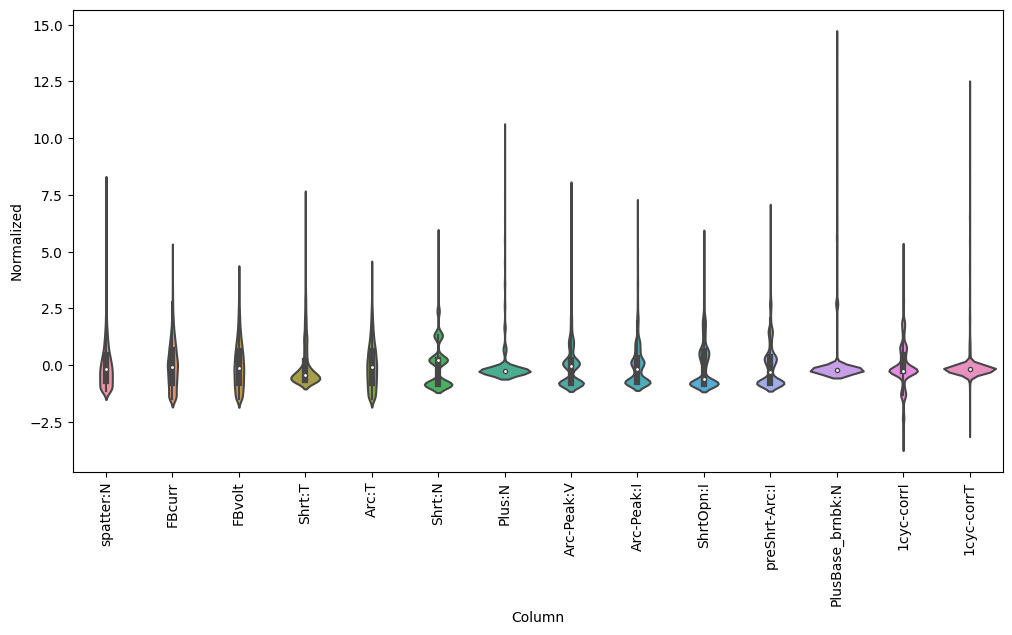

In [12]:
import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

train_mean = dataset.mean()
train_std = dataset.std()

df_std = (dataset - train_mean) / train_std

dataset_std = df_std
#df_std = df
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
#_ = ax.set_xticklabels(label_name, rotation=90)
_ = ax.set_xticklabels(dataset.columns, rotation=90)



In [13]:
dataset_std

,spatter:N,FBcurr,FBvolt,Shrt:T,Arc:T,Shrt:N,Plus:N,Arc-Peak:V,Arc-Peak:I,ShrtOpn:I,preShrt-Arc:I,PlusBase_brnbk:N,1cyc-corrI,1cyc-corrT
0,-0.979006,-1.118352,-1.174291,-0.612372,-1.254791,-0.852261,-0.261928,-0.803383,-0.758773,-0.819181,0.403550,-0.211069,-0.253720,-0.179661
1,0.253612,0.106475,-0.164083,-0.350401,-0.075974,1.304914,-0.261928,-0.110758,-0.298265,0.146895,0.546218,-0.211069,2.903332,-0.179661
2,-0.406719,-0.024325,-0.254150,-0.388872,-0.406210,-0.852261,-0.261928,0.152912,-0.343094,1.195672,2.632740,-0.211069,1.507823,-0.179661
3,0.561766,1.174342,0.949336,-0.363225,1.207349,-0.852261,-0.261928,0.741250,0.861154,1.376106,-0.791296,-0.211069,0.112315,-0.179661
4,-0.010520,0.385843,0.521397,-0.495126,0.463272,0.226327,-0.261928,0.064366,-0.559084,-0.080527,2.686240,-0.211069,0.821508,-0.179661
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5485,0.209590,0.269604,0.798170,0.316432,0.701544,-0.852261,-0.261928,-0.803383,-0.758773,0.408150,-0.791296,-0.211069,0.478350,-0.179661
5486,1.046009,0.953710,1.077620,0.875180,0.935635,0.226327,-0.261928,1.087563,1.007864,1.968157,0.161014,-0.211069,-0.253720,-0.179661
5487,1.530252,1.352525,1.865095,1.122495,1.805118,1.304914,-0.261928,0.127332,0.119452,-0.819181,-0.791296,-0.211069,-0.230843,-0.179661
5488,0.165568,0.432980,0.535029,0.611378,0.321145,-0.852261,-0.261928,-0.803383,-0.758773,0.654368,0.171714,-0.211069,-0.894281,-0.179661


In [14]:
#データを入力(X)１２個、出力(Y)１個に分ける
#CurrFB, VoltFBのうちCurrFBだけ除外してみる。
input_data = dataset_std.iloc[:, 2:14].values
output_data = dataset_std.iloc[:, 0:1].values
print( 'input_data=[', input_data.shape[0], ',', input_data.shape[1], ']')
print( 'output_data=[', output_data.shape[0], ',', output_data.shape[1],']')

input_data=[ 5490 , 12 ]
output_data=[ 5490 , 1 ]


In [15]:
Xdata=[]
Ydata=[]
#LSTM用にデータ加工
#入力データの時間：10x6ms 60ms間の傾向
look_back=3
number = int( output_data.shape[0] / look_back ) - 1
print('Number=',number)
for i in range(number):
    Xtimedata=[]
    data_head = i * look_back
    for j in range(input_data.shape[1]):
        Xtimedata.append(input_data[data_head:data_head+look_back,j])
    Xtimedata=np.array(Xtimedata)
    Xtimedata=Xtimedata.transpose()
    Xdata.append(Xtimedata)
    Ytimedata=[]
    sum=0
    for j in range(look_back):
        sum += output_data[data_head+j,0]
    Ytimedata.append(sum/look_back)
    Ydata.append(Ytimedata)

Number= 1829


In [16]:
Xdata=np.array(Xdata)
Ydata=np.array(Ydata)

print(Xdata.shape)
#print(Xdata)
print(Ydata.shape)
#print(Ydata)


(1829, 3, 12)
(1829, 1)


In [17]:
#ライブラリインポート
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.optimizers import Adam

In [18]:
input_data.shape[0]

5490

In [19]:
#学習用の情報指定
Xdim=Xdata.shape[2]
Ydim=Ydata.shape[1]
validation_split_rate=0.2
print('Xdim=',Xdim,', Ydim=',Ydim,', validation_split_rate=',validation_split_rate)

Xdim= 12 , Ydim= 1 , validation_split_rate= 0.2


In [20]:
#モデル構築
#LSTMレイヤを多層化して複雑な表現ができるようにする。
#LSTM(34,...の34はユニット数でより複雑で長期的な傾向を理解するためにはユニット数をある程度の大きさにする。

model = Sequential()
model.add(LSTM(35, return_sequences=True, input_shape=(look_back,Xdim)))
model.add(LSTM(35, return_sequences=True))
model.add(LSTM(35))
model.add(Dense(Ydim))
model.compile(loss="mean_squared_error", optimizer=Adam(learning_rate=0.001))
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 3, 35)             6720      
                                                                 
 lstm_1 (LSTM)               (None, 3, 35)             9940      
                                                                 
 lstm_2 (LSTM)               (None, 35)                9940      
                                                                 
 dense (Dense)               (None, 1)                 36        
                                                                 
Total params: 26,636
Trainable params: 26,636
Non-trainable params: 0
_________________________________________________________________


In [21]:
#学習開始
history=model.fit(Xdata,Ydata,batch_size=16,epochs=250,validation_split=validation_split_rate)

Epoch 1/250
92/92 [==============================] - 11s 28ms/step - loss: 0.3189 - val_loss: 0.1391
Epoch 2/250
92/92 [==============================] - 1s 12ms/step - loss: 0.0793 - val_loss: 0.0776
Epoch 3/250
92/92 [==============================] - 1s 11ms/step - loss: 0.0481 - val_loss: 0.0553
Epoch 4/250
92/92 [==============================] - 1s 12ms/step - loss: 0.0377 - val_loss: 0.0498
Epoch 5/250
92/92 [==============================] - 1s 12ms/step - loss: 0.0331 - val_loss: 0.0508
Epoch 6/250
92/92 [==============================] - 1s 11ms/step - loss: 0.0306 - val_loss: 0.0558
Epoch 7/250
92/92 [==============================] - 1s 11ms/step - loss: 0.0299 - val_loss: 0.0481
Epoch 8/250
92/92 [==============================] - 1s 11ms/step - loss: 0.0311 - val_loss: 0.0454
Epoch 9/250
92/92 [==============================] - 1s 16ms/step - loss: 0.0272 - val_loss: 0.0482
Epoch 10/250
92/92 [==============================] - 1s 16ms/step - loss: 0.0273 - val_loss: 0.049

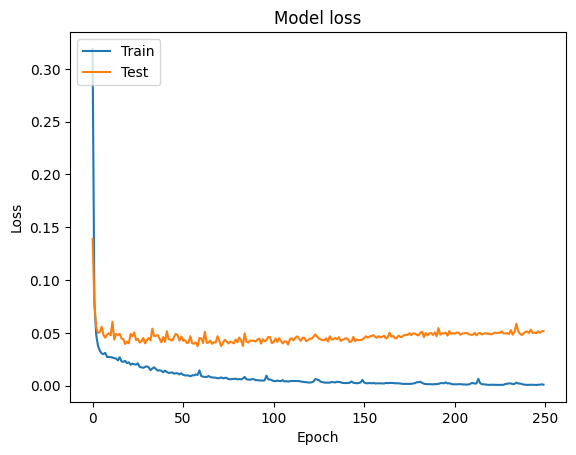

In [22]:
#学習履歴のグラフ化
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [23]:
#学習データから学習時にテストデータとして用いた部分を取り出す
Xdata_validation=Xdata[-int(len(Xdata)*(validation_split_rate)):]
Ydata_validation=Ydata[-int(len(Ydata)*(validation_split_rate)):]

12/12 [==============================] - 1s 4ms/step


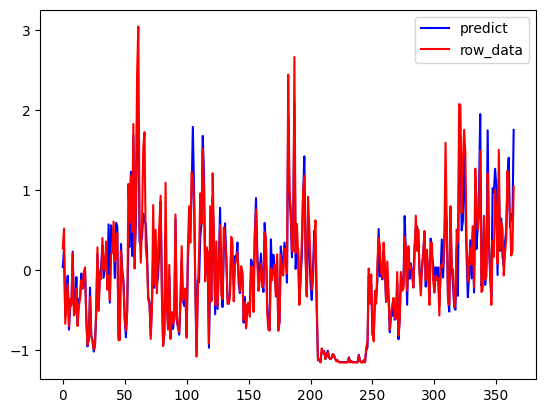

In [24]:
#テスト
Predictdata = model.predict(Xdata_validation)
#テスト結果のグラフ化
plt.plot(range(0, len(Predictdata)),Predictdata[:,0], color="b", label="predict")
plt.plot(range(0, len(Ydata_validation)),Ydata_validation[:,0], color="r", label="row_data")
plt.legend()
plt.show()

In [25]:
import pandas as pd
predict_df = pd.DataFrame(Predictdata, columns=["predict"])
validation_df = pd.DataFrame(Ydata_validation, columns=["row_data"])
predict_df.to_csv("/content/drive/MyDrive/Colab Notebooks/LSTM_try04-7_RENEW_Alldata_prediction.csv", index=False)
validation_df.to_csv("/content/drive/MyDrive/Colab Notebooks/LSTM_try04-7_RENEW_Alldata_validation.csv", index=False)
